本文是对PyTorch Tutorials的学习，原文地址https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html,
编辑:weiyang,微信:damo894127201,Time:2019.2.2

这里，我们将会构建和训练一个基础的character-level RNN 来分类单词。character-level RNN读取一系列字符(字母)，每个时间步timestep输出预测值和hidden state,然后将此hidden state输入给下一个时间步。我们将最后一个时间步timestep的预测值作为RNN的输出，也就是类别。

具体来说，我们将训练来自18种原始语言的几千个姓氏，并根据拼写预测名称来自哪种语言。

```Python
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Preparing the Data

data/names目录下有18个命名格式为[language].txt的文本文件。每个文件包含一堆names，每个name一行，主要是罗马化的，但我们仍然需要将它们从Unicode编码转为ASCII编码。最后，我们将对每种语言生成一个字典，其值为name的列表，即{language:[names,...]}。通用变量'category'和'line'(这里分别指代language和name)用于稍后的扩展。

In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import glob  # 使用通配符查找文件目录和文件的模块
import os
import unicodedata # 将文本编码标准化
import string

## 生成模型的字符列表

string.ascii_letters 生成26个字母，包含大小写

string.digits 生成0-9的数字

In [2]:
all_letters = string.ascii_letters + " .,;'-" # 所需要的字符集合
n_letters = len(all_letters) # 字符类别个数

## 定义利用通配符查找文件的函数

glob模块支持 * ? [] 三种通配符

1. \*代表0个或多个字符
2. ?代表一个字符
3. []匹配指定范围内的字符，如[0-9]匹配数字

glob.glob(regx):返回符合条件的文件列表

glob.iglob(regx):返回符合条件的文件迭代器，适合于大量文件的目录

In [3]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('./data/names/*.txt'))

['./data/names/English.txt', './data/names/Korean.txt', './data/names/Greek.txt', './data/names/Czech.txt', './data/names/Polish.txt', './data/names/Chinese.txt', './data/names/Japanese.txt', './data/names/Vietnamese.txt', './data/names/Scottish.txt', './data/names/French.txt', './data/names/Russian.txt', './data/names/Portuguese.txt', './data/names/Dutch.txt', './data/names/German.txt', './data/names/Arabic.txt', './data/names/Spanish.txt', './data/names/Irish.txt', './data/names/Italian.txt']


## 将Unicode字符串转为纯ASCII字符串:字符串标准化

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s) # 把Unicode字符转为Normalization Form D(NFD)格式的字符串
        if unicodedata.category(c) != 'Mn' # 该字符c在unicode分类的类型，不是 Mark, Nonspacing
        and c in all_letters
    ) # join()里其实是个列表推导

print(unicodeToAscii('Ślusàrski'))

Slusarski


## 读取文件并将其分割成一行一行

In [5]:
def readLines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

## 构建{语言类别:names}字典，其中names是个name列表

In [6]:
category_lines = {}
all_categories = []
# 遍历data/names文件下的文件
for filename in findFiles('data/names/*.txt'):
    # os.path.basename(filename)返回filename最后位置处的文件名
    # os.path.splitext（）分离文件名与扩展名
    category = os.path.splitext(os.path.basename(filename))[0]# 获取语言类别
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories) # 语言类别个数

现在我们便得到了**category_lines**,它是一个language到name列表的字典，即{language:[names,...]}。我们也记录了语言类别**all_categories**和语言类别个数**n_categories**。

In [7]:
print(category_lines['Italian'][:5]) # 输出意大利语下面的前5个name

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors：将name转为Tensors

现在我们需要将name转为tensor以便使用它们。这里，用**1 x n_letters**维度的one-hot向量来表示单个字符(字母)，例如，b可表示为(0,1,0,0,..0)。因此，对于某个单词word而言，可表示为一个二维矩阵,word_length x 1 x n_letters 。

额外的1维是因为PyTorch假定所有东西都是批量的 - 我们这里只是使用批量大小为1。

### 查找字母在字符列表中的索引编号

In [8]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

### 将字符转为one-hot向量

In [9]:
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

### 将name转为tensor，size为name_length x 1 x n_letters

In [10]:
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li,letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [11]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])
torch.Size([5, 1, 58])


# Creating the Network

搭建一个RNN需要复制每一时间步的参数，并且网络保存的hidden state和梯度会由计算图处理。这意味着你可以以很纯粹的方式实现RNN，就像通常的前馈神经网络那样。

RNN仅有两个线性层，并且以input和hidden state 为输入，在output后便是LogSoftmax层。

![RNN_classifying](./image/RNN_classifying.png)

In [12]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,inputs,hidden):
        combined = torch.cat((inputs,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

我们需要给网络传递一个输入(这里，是当前字母的Tensor)和前一个隐藏状态(初始时，我们置为0)。我们将会返回输出output(即每种语言类别的概率)和当前时刻的隐状态。

In [13]:
inputs = letterToTensor('A')
hidden = torch.zeros(1,n_hidden)
output,next_hidden = rnn(inputs,hidden)

考虑到效率，我们并不想每一步都为单个字母创建一个Tensor，因此我们调用**lineToTensor()**函数，而不是**letterToTensor()**,并使用切片。这些都会在批处理时，做进一步的优化。

In [14]:
inputs = lineToTensor('Albert')
hidden = torch.zeros(1,n_hidden)

output,next_hidden = rnn(inputs[0],hidden)
output

tensor([[-2.9248, -2.8686, -2.8780, -2.9252, -2.9077, -2.8847, -2.8637, -2.8739,
         -2.7826, -2.8916, -2.9324, -2.9592, -2.8987, -2.9042, -2.8950, -2.8131,
         -2.9595, -2.8807]], grad_fn=<LogSoftmaxBackward>)

输出output是一个**1 x n_categories **的张量，其中每一维的值是相应编号类的概率，值越大概率越大。

# Training 

## Preparing for Training

在训练网络之前，我们需要写一些辅助函数，比如，用来解释网络输出output的辅助函数，而网络输出我们知道那是每一个语言类别的输出概率。我们可以使用**Tensor.topk**来获取概率最大的类别对应的索引编码。

In [15]:
def categoryFromOutput(output):
    top_n,top_i = output.topk(1) # top_n对应的是概率值,top_i对应的是索引,维度都是k*1
    category_i = top_i[0].item()
    return all_categories[category_i],category_i # 返回类别和类别编码

print(categoryFromOutput(output))

('Scottish', 8)


快速获取训练数据

In [16]:
import random

def randomChoice(lst):
    return lst[random.randint(0,len(lst)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category,line,category_tensor,line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Than
category = Japanese / line = Yamagata
category = Korean / line = Choe
category = French / line = Allard
category = Chinese / line = Gui
category = Italian / line = Nicchi
category = German / line = Straub
category = Russian / line = Mstislavets
category = Polish / line = Sokolowski
category = Korean / line = Ryu


## Training the Network

经过以上准备工作，现在训练网络所需的就是灌进一批数据，然后预测，再比较预测结果与真实值。对于损失函数用**nn.NLLLoss**，是由于RNN的最后一层是**nn.LogSoftmax**。

In [17]:
loss_func = nn.NLLLoss()

每次循环的训练都会：
1. 创建input和target tensors
2. 创建一个初始的值为0的hidden state
3. 读取每个字母(字符)，并为下一个字母保留hidden state
4. 将输出与target做比较
5. 反向传播
6. 返回输出和loss

In [18]:
learning_rate = 0.005 #学习率如果设置太大，会产生梯度爆炸；太小，RNN就学不到东西了

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # 初始化RNN的hidden state为0

    rnn.zero_grad() # 清空RNN梯度缓存池中的梯度

    for i in range(line_tensor.size()[0]): # 遍历name中的每个字母
        output, hidden = rnn(line_tensor[i], hidden)

    loss = loss_func(output, category_tensor) # 计算损失
    loss.backward() # 反向传播

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data) # 更新网络权重

    return output, loss.item() # 返回输出和损失

现在我们已经在批量数据上将RNN跑了起来。由于**train**函数同时返回网络输出和损失，我们可以输出RNN猜测的类别，记录损失并展示其变化曲线。总共有1000条数据，我们每隔**print_every**输出损失，并对损失取平均。

In [19]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.2779 Tagawa / Japanese ✓
10000 10% (0m 14s) 2.3212 Phocas / Arabic ✗ (Greek)
15000 15% (0m 21s) 2.7740 Bakis / Greek ✗ (Russian)
20000 20% (0m 27s) 0.1441 Kozlowski / Polish ✓
25000 25% (0m 32s) 3.8316 Hargreaves / Greek ✗ (English)
30000 30% (0m 38s) 1.3655 Wondracek / Dutch ✗ (Czech)
35000 35% (0m 43s) 1.1584 Traverse / French ✓
40000 40% (0m 48s) 0.2790 Quach / Vietnamese ✓
45000 45% (0m 55s) 1.2893 Melo / Spanish ✗ (Portuguese)
50000 50% (1m 1s) 0.8339 Oinuma / Japanese ✓
55000 55% (1m 6s) 1.2179 Walentowicz / Polish ✓
60000 60% (1m 12s) 0.7997 Babuhin / Russian ✓
65000 65% (1m 18s) 1.5098 Polites / Spanish ✗ (Greek)
70000 70% (1m 24s) 3.6163 Douglas / Greek ✗ (Scottish)
75000 75% (1m 31s) 4.0112 Serafin / Dutch ✗ (Polish)
80000 80% (1m 37s) 0.2667 Terakado / Japanese ✓
85000 85% (1m 44s) 2.2758 Hay / Chinese ✗ (Scottish)
90000 90% (1m 50s) 0.1164 Tupolev / Russian ✓
95000 95% (1m 57s) 0.0654 Dinh / Vietnamese ✓
100000 100% (2m 5s) 2.6306 Desmond / English ✗ (Iris

## Plotting the Results

展示RNN的损失曲线

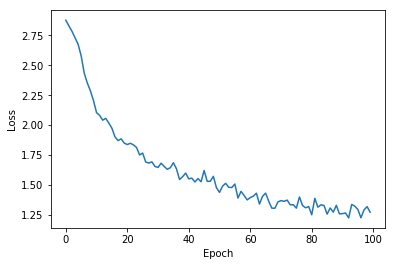

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluating the Results

我们想知道RNN在不同类别上学习的结果，因此创建一个混淆矩阵。为了计算混淆矩阵，一堆数据经过RNN并用函数**evaluate()**来评估，除了没有反向传播，它与**train**函数并无多大差异。

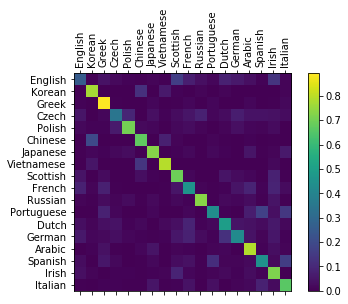

In [21]:
# 记录混淆矩阵中预测正确的个数
confusion = torch.zeros(n_categories,n_categories)
n_confusion = 10000

# 返回每个输入name的返回值(类别)
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    
    return output

# 在大量数据上训练RNN，并记录预测准确的个数
for i in range(n_confusion):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess,guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum() # 计算相应类别的准确率

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy()) # 混淆矩阵可视化
fig.colorbar(cax)

# set up axes
ax.set_xticklabels([''] + all_categories,rotation=90) 
ax.set_yticklabels([''] + all_categories)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

你可以从主轴上挑出比较亮的点来查看它猜错的语言，例如： 汉语预测为韩语，西班牙语预测为意大利语。 RNN似乎在希腊语上预测很好，而在英语上很差（可能是因为英语与其他语言的重叠）。

# Running on User Input:预测

In [22]:
def predict(input_line,n_predictions=3): # 输出概率最大的前n_predictions个预测结果
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        # get top N categories
        topv,topi = output.topk(n_predictions,1,True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.30) Russian
(-1.70) Czech
(-3.36) English

> Jackson
(-0.81) Scottish
(-1.20) English
(-2.06) Russian

> Satoshi
(-1.15) Polish
(-1.74) Arabic
(-2.02) Italian
